# GDAS App via Global-Workflow on Hercules / Orion
### ReneDiego Martinez - Texas A&M University Corpus Christi
07/20/2024
  


This guide will allow users to install the GDAS App via Global-Workflow on NOAA HPCs Hercules and Orion. 

Before beginning the tutorial, please review the below documentation to familiarize yourself with the components of GDAS and the global-workflow. 
#### Fix/Static Files
  - GDAS fix files via global-workflow
    - /path/to/global-workflow/directory/"gdas-app"/global-workflow/parm/gdas/io
  - Initial Conditions
    - The global workflow has two types of Initial Conditions based on the experiment start type (Cold or Warm)
      - This tutorial uses a cold start, which means and Initial Conditions converted by the chgres_cube utility should work. 
      - See [documentation](https://global-workflow.readthedocs.io/en/latest/init.html) for additional details.
  - Observation / Dump Data
    - The Global Dump Archive (GDA) files are observation data used when running a cycling experiment. This data is available on Tier 1 Platforms.
      - On Hercules/Orion, the data is located in the following directory.
          - /work/noaa/rstprod/dump
## Config YAMLs
  - Several configuration files are used throughout the experiment.
      - Machine specific YAMLs are found in the global-workflow repository and define variables specific to the machine itself.
      - /path/to/global-workflow/"gdas-app"/global-workflow/workflow/hosts/(machine_name).yaml
          - (machine_name) can either be "hercules" or "orion".
  - For this experiment, the atmDA.yaml is used by the setup_expt.py script to modify the machine YAML and sources the default GFS YAML.
      - GFS YAML is located here:
          - /path/to/global-workflow/directory/"gdas-app"/global-workflow/parm/config/gfs/yaml/defaults.yaml
  - Once the experiment is created, around 90 configuration files are generated. Not all are used in this experiment. The configuration files that are used share the same configuration name as the task name. The configuration files from this experiment are located here:
      - /path/to/global-workflow/directory/"gdas-app"/expdirs/gw_atm
## Workflow Tasks
- The following graphic shows the common steps a single workflow task moves through once the job_card is submitted.
  - A number of files are sourced or initiated before the job script runs.
      - Depending on the task, either the exglobal script or the ush script runs.
      - For some tasks, both of these options run with the exglobal script being initiated first.
      -  Lastly, executable(s) may run after that step, depending on the first task.
 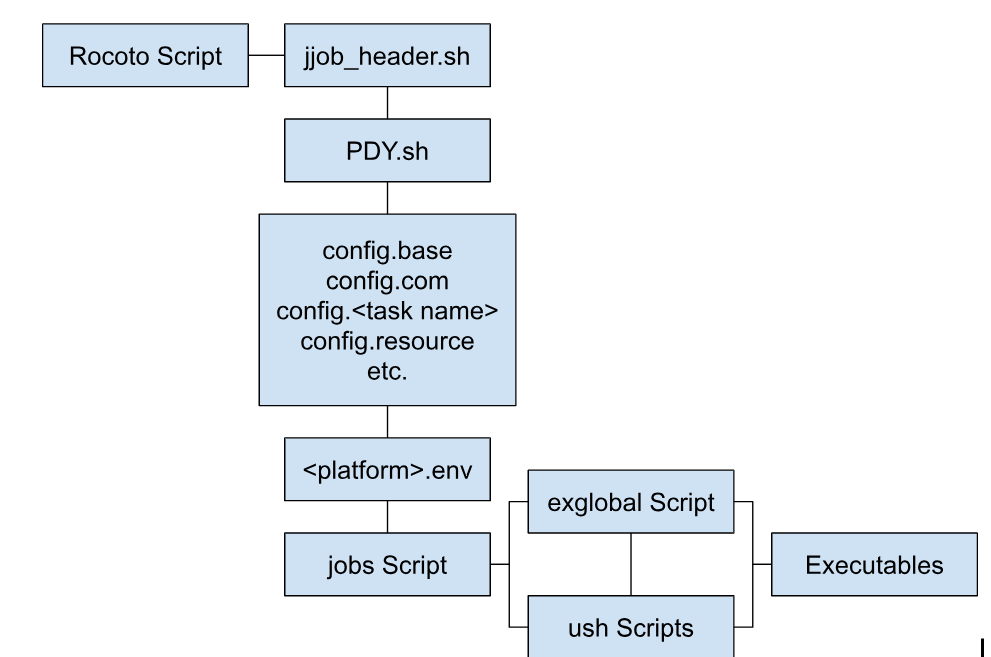
Fig. 1 General Steps a single workflow task moves through. (Edward Snyder, NOAA)
 - For more details, please review this [documentation](https://docs.google.com/spreadsheets/d/e/2PACX-1vRR9vmqLmMHBvQ-RJgeoqZZ5UzeFiyXIBBbaT1gUJo1PAZk6EvxDAm7DQlHuNtcVENnXvBAjq1AD0uw/pubhtml)
## Output Files
- Several types of output files are generated from this experiment.
  - The "gdasfcst" task outputs: 'logf', 'atmf', and 'sfcf' netCDF files to the comroot directory. For this experiment, they are located in this directory.
      - /path/to/global-workflow/directory/"gdas-app"/comroot/gw_atm/gdas.20211221/00/model_data/atmos/history
  - This task also generates the restart files in this directory:
      - /path/to/global-workflow/directory/"gdas-app"/comroot/gw_atm/gdas.20211221/00/model_data/atmos/restart
  - The product generation task (gfsatmos_prod) creates grib2 files at different grid sizes (0p25, 0p50, 1p00). These files are located in this directory:
      - /path/to/global-workflow/directory/"gdas-app"/comroot/gw_atm/gdas.20211221/00/products/atmos/grib2/#p##

# Building GDAS via Global-Workflow

Before building the global-workflow, make sure to remotely connect to Hercules/Orion and ensure that you have a secure, stable  connection to smoothly build the application.  
  - Use PuTTY, terminal, or another application to access Hercules/Orion.

## Building the Global-Workflow 
- This step clones the global-workflow directory from this [git repository](https://github.com/NOAA-EMC/global-workflow)
    1. git clone --recursive https://github.com/NOAA-EMC/global-workflow
    2. cd global-workflow/sorc
    3. ./build_all.sh -gu
       - g = builds Data Assimilation Apps
       - u = builds coupled cycling apps
    4. ./link_workflow.sh
- The global workflow will be built in the directory that you run these commands in. For my example, the global-workflow was build in Hercules in this location:
    - /work/noaa/epic/diegom/GDAS-App/global-workflow/
    - See [documentation](https://global-workflow.readthedocs.io/en/latest/clone.html) for more information on building the global workflow.


## Running GDAS App via Global-Workflow
1. Setup Environment
  - cd gdas.cd
  - module use /path/to/global-workflow/"gdas-app"/global-workflow/sorc/gdas.cd/modulefiles
  - module load GDAS/< hercules.intel | orion.intel >
      - **Ensure you load the correct module with the corresponding HPC you are using. ie. module load hercules.intel if you are using Hercules.**
2. Create and Setup Experiment
  - cd /path/to/global-workflow/"gdas-app"/global-workflow/workflow
  - Create the atmDA.yaml file
      - This file modifies the default gfs yaml.
      - You can create the file by using command:
          - "vi atmDa.yaml"
          - Once created, edit the file to match the text below:  
              -  defaults:   
              - !INC {{HOMEgfs}}/parm/config/gfs/yaml/defaults.yaml  
              - base:  
                - DOIAU: "NO"
                - DO_JEDIATMVAR: "YES"
                - ACCOUNT: "epic"
                - HPSSARCH: "NO"
                - HOMEDIR: "/path/to/home/directory"
                    -  **Use the path to your home directory.**
                    -  **Example: /work/noaa/epic/$diegom.**
3. Create experiment
- Before creating the experiment, it is important to note that the data used in this experiment is pre-staged and is stored in the '[rstprod](https://www.nco.ncep.noaa.gov/pmb/docs/restricted_data/#whatis)' directory. Some things to note about 'rstprod'; the directory contains observational data that is updated daily and uploads data with a 48hr time delay. Rstprodhas limited access. To test if you have access, simply try to move into the rstprod directory; the path is /work/noaa/rstprod/dump. If you do not have access, you can apply [here](https://www.nco.ncep.noaa.gov/pmb/docs/restricted_data/register/).
    -  **If you are still denied access to the rstprod directory, you can substitute the restricted data path with this path: /work/noaa/epic/role-epic/contrib/gdas-data**
        -  **The data from this directory contains observational data dumps from 12/21/2021, and can be utilized as a test run.**
        - To select the observational dump for your experiment, you can modify the initial/end date of the analysis;
            - **To change the idate/edate for your experiment, input the date in this format (yyyymmddhh)**
- **Ensure that the code is verbatim with the tutorial. As an example, my "/example/directory/path/for/tutorial/.../"gdas-app"/ directory would be listed as: /work/noaa/epic/diegom/GDAS-App/...**
  - In Hercules/Orion, the data for the rstprod directory is located in this path:
    - /work/noaa/rstprod/data/dump
- **To create the experiment for testing, run the below command:**
  - ./setup_expt.py gfs cycled --pslot gw_atm --resdetatmos 96 --comroot /example/directory/path/for/tutorial/.../"gdas-app"/comroot/ --expdir /example/directory/path/for/tutorial/.../"gdas-app"/expdirs --icsdir /work/noaa/rstprod/data/ICSDIR/C96C48 --idate 2021122012 --edate 2021122100 --nens 0 --gfs_cyc 1 --yaml atmDA.yaml
      - ICSDIR designates the location of the intial conditions for your experiment. 
4. Finalize experiment 
- This command sets up the experiment by locating and activating the configuration files in the expdirs directory.
- **Before running setup_xml.py, ensure that you have run the command "./link_workflow.sh" in the /.../global-workflow/sorc directory. Once the script completes you can run the below command.**
    - **./setup_xml.py /example/directory/path/for/tutorial/.../"gdas-app"/expdirs/gw_atm**
    - Example: ./setup_xml.py /work/noaa/epic/diegom/GDAS-App/expdirs/gw_atm

5. Run and Check Experiment
  - This step is the bread and butter of the GDAS Application. With these two commands, you can successfully intitate and complete a run of the experiment.
      - **Before using the [rocoto workflow management system](https://christopherwharrop.github.io/rocoto/), a previous version of rocoto must be loaded as a module.**
        -  To load the previous version, run **"module load rocoto/1.3.7"** in the command line before running the experiment.
      - **Additionally, you may encounter an error with dead/failed tasks regarding the path locations in  "gw_atm.xml" and "config.base" files when running the rocoto command.**
          - **To resolve this error, run these two commands in your /path/to/expdirs/gw_atm directory:**
              - sed -i 's|stmp|epic|g' gw_atm.xml
              - sed -i 's|stmp|epic|g' config.base
                  - Once these commands are ran, use the rocotorewind command to restart failed/dead tasks.
      - Additionally, in your .../expdirs/gw_atm directory, you will have to modify the config.base file and the gw_atm.xml file
          - Inside the config.base file:
              - Locate the "MAKE_NSSTBUFR" variable and set "MAKE_NSSTBUFR" to "YES"
                  - Example: export MAKE_NSSTBUFR="YES"
          - Inside the gw_atm.xml file:
              - Locate the variable "< "account >fv3-cpu<"/account> and update it to:
                  - <"account>epic</account">
  - To run and check the experiment:
      - cd /example/directory/path/for/tutorial/.../"gdas-app"/expdirs/gw_atm
        - Example: cd /work/noaa/epic/diegom/GDAS-App/expdirs/gw-atm
      - rocotorun -w gw_atm.xml -d gw_atm.db
      - rocotostat -w gw_atm.xml -d gw_atm.db
        - When running the experiment, periodically re-run the rocotorun/rocotostat commands above to queue new tasks and to check the status of running tasks if they have completed.
    - If one of the tasks fails or is labeled as dead, the task can be restarted. To do this, run the below command in your experiment directory /.../expdir/gw_atm
        - rocotorewind -w gw_atm.xml -d gw_atm.db -v 10 -c (YYYY/MM/DD/HHHH) -t (Task Name)
        -  Example: "rocotorewind -w gw_atm.xml -d gw_atm.db -v 10 -c 202112201200 -t gdasfcst"
      
    

## Viewing